# Lab 6, unsupervised learning

## Objectives: 
1. train a Gaussian NBC with the EM algorithm (Expectation - Maximisation)
2. compare the results you get to those of the k-Means clustering provided in SciKitLearn
3. discuss the classifiers from this lab session and those from the previous session (supervised learning of NBCs) in a brief report

## Background and Tools
The EM  algorithm solves the problem of not being able to compute the Maximum Likelihood Estimates for unknown classes directly by iterating over two steps until there is no significant change in step 2 observable:

1. Compute the expected outcome for each example / sample given estimates for priors and distribution (essentially, the likelihoods for observing the sample assuming an estimated distribution).  
2. Compute new estimates for your priors and distributions (in the case of a Gaussian NBC, new means and variances are needed) based on the estimated expected values for how much each sample belongs to the respective distribution.

You can find the algorithm stated explicitly as given in Murphy, "Machine Learning - A probabilistic perspective", pp 352 - 353 http://fileadmin.cs.lth.se/cs/Education/EDAN95/Handouts/EM-algo.pdf.

One special case of the EM algorithm is k-Means clustering, for which an implementation can be found in SciKitLearn.

## Your implementation task
1. Implement the EM-algorithm to find a Gaussian NBC for the digits dataset from SciKitLearn (you can of course also use the MNIST_Light set from Lab 5, but for initial tests the digits data set is more convenient, since it is smaller in various aspects). You may assume (conditional) independence between the attributes, i.e., the covariances can be assumed to be simply the variances over each attribute. Split the data set in 70% training and 30% test data.

### Digits

<Figure size 432x288 with 0 Axes>

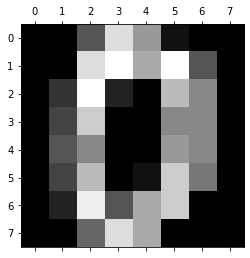

(1257, 64)

In [120]:
%matplotlib inline
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
import numpy as np
from numpy import linalg as la

digits =  load_digits()
plt.gray() 
plt.matshow(digits.images[0])
plt.show() 

split = int(len(digits.data)*0.7)

data_1_train = digits.data[:split]
data_1_test = digits.data[split+1:]
labels_1_train = digits.target[:split]
labels_1_test = digits.target[split + 1:]
np.shape(data_1_train)

### Implement the EM-algorithm

In [170]:
import random
X = data_1_train
M = np.mean(X)
S = np.std(X)
X = (X - M) / S
K = 10
N, n_pix = np.shape(X)
# These factors are to make the systems somewhat stable. But hardky work.
sig_factor = 5e2          # 5e2
partial_factor = 2e1      # 2e1

# 1 initilize theta_k = (pi_k, mu_k, sigma_k)
# pi_k = prior for class k (assume uniform distr.)
Pi = np.ones(K)/K

# mu_k = mean for class k (random subset of the data)
# sigma_k = covariance for class k (variance of data)
Mu = np.zeros([K, n_pix])
Sigma2 = np.zeros([K, n_pix])
epsilon = 1e-3
for k in range(K):
    idx = np.random.choice(N, int(N/K))
    temp_data = X[idx]
    Mu[k,:] = np.mean(temp_data, 0)
    for p in range(n_pix):        
        Sigma2[k, p] = sig_factor * (np.mean((temp_data[:, p] - Mu[k,p]) ** 2) + epsilon)


# 2 iterate over E and M step
itr = 1
errs = 0
while True:      # make some stop criterium
    # E: 
    # 2.2 where P(x_i|thetaold_k) = prod_j(exp(-(x-muold_kj)^2 / 2*sigma_kj^2) / sqrt(2*åi*sigma_kj^2))
    Post = np.ones([N, K])
    m = 1e6
    for n in range(N):   # To many loops but I am tired
        for k in range(K):
            for p in range(n_pix): #2e1
                partial_post = partial_factor * np.exp(-(X[n, p]- Mu[k, p])**2 / (2 * Sigma2[k, p])) / np.sqrt(2 * np.pi * Sigma2[k, p])
                if partial_post < m:
                    m = partial_post
                if partial_post == 0.0:
                    errs += 1
                    break
                Post[n, k] *= partial_post
            if errs:
                break
        if errs: 
            break
    print('1', m)
    print('#ERRORS: ', errs)
    if errs:
        break
    #break
    # 2.1 rnew_ik = piold_k * P(x_i|thetaold_k) / (sigmaold_k * piold_k * P(x_i|thetaold_k))
    # rnew is p(class| pixel/image) 
    r = np.zeros([N, K])
    m = 1e6
    for n in range(N):
        r_row = np.zeros(K)
        for k in range(K):
            r_row[k] = Post[n, k] * Pi[k]
        if sum(r_row) < m:
            m = sum(r_row)
        r[n, :] = r_row / sum(r_row)

    print('2', m)
    # M: 
    # rnew_k = sum_i(rnew_ik), pinew_k = rnew_k / N
    rk = sum(r, 0)
    Pi = rk / N 
    print('min pi is: ', np.min(Pi))

    # munew_k = sum_i(rnew_ik*xi)/rnew_k, 
    # sigmanew_k = sum_i(rnew_ik*<xi,xi>) / rnew_k -<munew_k,munew_k> (simplified and took variance)
    Mu_new = np.zeros([K, n_pix])
    Sigma2_new = np.zeros([K, n_pix])
    for k in range(K):
        for p in range(n_pix):
            Mu_new[k, p] = np.dot(r[:,k], X[:,p]) / rk[k]
            Sigma2_new[k, p] = sig_factor * (np.dot(r[:, k], (X[:, p] - Mu[k, p]) ** 2) / rk[k] + epsilon)

    print('steps at iteration ', itr, ': ', la.norm(Mu_new - Mu), la.norm((Sigma2_new - Sigma2)/sig_factor), '\n')
    Mu = Mu_new
    Sigma2 = Sigma2_new
    # 3 stop when mu and sigma has converged
    itr += 1
    if itr > 5:
        break
Pi

1 0.04938606838033364
#ERRORS:  0
2 0.011173573597267217
min pi is:  1.1478959252545075e-05
steps at iteration  1 :  1.9903909357162513 1.9842265485074075 

1 0.32533522382594116
#ERRORS:  0
2 0.0024044466388150223
min pi is:  6.919811961213282e-08
steps at iteration  2 :  1.0723471579451844 1.360785660720532 

1 0.32788645252624526
#ERRORS:  0
2 0.0009462601047949713
min pi is:  2.0966086461450085e-08
steps at iteration  3 :  0.11320919311703498 0.24102305268122068 

1 0.32814821926969295
#ERRORS:  0
2 0.0009520204730891964
min pi is:  1.79280423293713e-08
steps at iteration  4 :  0.017547460555408987 0.022742509250965784 

1 0.3281483625605881
#ERRORS:  0
2 0.0009520208115412713
min pi is:  1.740082663463787e-08
steps at iteration  5 :  0.0027389459256805236 0.003460391583741235 



array([6.00141841e-06, 1.74008266e-08, 3.93924813e-06, 3.95617502e-05,
       1.74022264e-06, 9.92325471e-01, 5.27997737e-03, 1.86650990e-03,
       1.01619926e-04, 3.75161687e-04])

In [132]:
# Just me testing stuff

mat = np.random.rand(2, 3)
for i in range(3):
    mat[:,i] /= sum(mat[:,i])
i,j=np.shape(mat)
v = np.ones(2)
print(mat)
r = np.random.choice(10, 3)
v = np.array([1,2,3,4,5,6,7,8,9, 10])
v[r]
np.sum(mat,1)
np.max(data_1_train)
X = data_1_train
M = np.mean(X)
S = np.std(X)
X = (X - M) / S
np.min(X)


[[0.55814516 0.47337239 0.81463811]
 [0.44185484 0.52662761 0.18536189]]


-0.8145905601913872

2. Use the result of the EM-algorithm (the found distribution parameters) to cluster the training data (essentially, using the resulting classifier to do a prediction over the training data). Produce a confusion matrix over the known labels for the training data and your EM-generated clusters. What do you see?


3. If necessary, find a way to "repair" the cluster assignments so that you can do a prediction run over the test data, from which you can compare the results with your earlier implementation of the Gaussian NBC.


4. Use now also the k-Means implementation from SciKitLearn and compare the results to yours (they should be similar at least in the sense that there are classes that are more clearly separated from the rest than others for both approaches). 


### Your reporting task
Write a brief (1-2 pages) report that discusses the following issues / answers the following questions. Give proper references in case you consult any material other than your implementation. 

1. In lab 5 you were asked to implement the "statistics based" NBC using counts over the encountered values for the attributes in each class. Why was that an oversimplification and how does the resulting problem relate to your first implementation of the decision tree in lab 2 for the digits data? 

2. The issue above was handled by switching to Normal distributions instead of the count based approach. Mitchell (see lecture slides lecture 10) suggests the m-estimate to solve the problem. What does the m-estimate do?

3. In lab 5 you implemented a Nearest-Centroid-Classifier (NCC) and a Gaussian NBC. How are those related?

4. Further, what is the relationship between the NCC and the result of the k-Means?

5. Explain in your own words the difference between k-Means clustering and the basic EM for GMMs as given in the Murphy-book (see above).

Submit the report in PDF-format (nothing else will be considered in this case) according to the instructions. OBS, this is Assignment 3 (report lab 6).